In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cmcrameri.cm as cm
import torch
import math
import time

from pymatgen.io.cif import CifParser
from pymatgen.core import Structure
from pymatgen.transformations.standard_transformations import RotationTransformation

from typing import Tuple, List, Dict, Optional, Union
from matplotlib.figure import Figure
from torch import Tensor

In [2]:
dtype = torch.float32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(dtype)

In [3]:
props = fm.FontProperties(family=['Lato', 'sans-serif'], size='large')
    
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.linewidth'] = 1

def format_axis(ax, props, xlabel='', ylabel='', title='', xbins=None, ybins=None):
    ax.set_xlabel(xlabel, fontproperties=props)
    ax.set_ylabel(ylabel, fontproperties=props)
    ax.set_title(title, fontproperties=props)
    ax.xaxis.offsetText.set_fontproperties(props)
    ax.yaxis.offsetText.set_fontproperties(props)
    
    for label in ax.get_xticklabels(which='both'):
        label.set_fontproperties(props)
    for label in ax.get_yticklabels(which='both'):
        label.set_fontproperties(props)
        
    if xbins:
        try: ax.locator_params(axis='x', nbins=xbins)
        except: ax.locator_params(axis='x', numticks=xbins+1)
            
    if ybins:
        try: ax.locator_params(axis='y', nbins=ybins)
        except: ax.locator_params(axis='y', numticks=ybins+1)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Adapted from: https://gist.github.com/salotz/4f585aac1adb6b14305c
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(
        n=cmap.name, a=minval, b=maxval), cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
class Detector:
    """
    Class representing a detector for BCDI simulation.
    """
    
    def __init__(
        self,
        num_pixels_i: int,
        num_pixels_j: int,
        pixel_size: float,
        distance: float,
        wavelength: float,
        dtype: torch.dtype = torch.float32,
        device: str = 'cuda'
    ):
        """
        Initialize a detector object.
        
        Parameters:
        -----------
        num_pixels_i: int
            Number of pixels in the vertical detector dimension
        num_pixels_j: int
            Number of pixels in the horizontal detector dimension
        pixel_size: float
            Size of each pixel in meters
        distance: float
            Sample-to-detector distance in meters
        wavelength: float
            X-ray wavelength in meters
        dtype: torch.dtype
            torch data type
        device: str
            torch device ('cuda' or 'cpu')
        """
        
        self.num_pixels_i = num_pixels_i
        self.num_pixels_j = num_pixels_j
        self.pixel_size = pixel_size
        self.distance = distance
        self.wavelength = wavelength
        self.dtype = dtype
        self.device = device
        
        # Calculate k vector magnitude |k| = 2π/λ
        self.k_magnitude = 2 * torch.pi / wavelength
        
        # Create pixel grid
        self._create_pixel_grid()

    @staticmethod
    def round_in_base(x: float, digits: int = 2, base: int = 10) -> float:
        """
        Round a number to the specified significant digits in the given base.
        
        Parameters:
        -----------
        x: float
            Number to round
        digits: int
            Number of significant digits to maintain when rounding
        base: int
            Base in which to round to the nearest power
            
        Returns:
        --------
        float:
            Rounded number
        """
        
        if x == 0:
            return 0
        else:
            exponent = np.floor(math.log(abs(x), base))
            scale = base ** (exponent - digits + 1)
            rounded = round(x / scale) * scale
            
            return type(x)(rounded)

    def plot_q_vectors(self, q_vectors: Tensor) -> Figure:
        """
        Plot the q vector components for each detector pixel.
        
        Parameters:
        -----------
        q_vectors: torch.Tensor
            q vectors for each pixel as a tensor of shape [num_pixels_i, num_pixels_j, 3]
            
        Returns:
        --------
        matplotlib.figure.Figure:
            Figure of the resulting plot
        """
        
        vmax = [Detector.round_in_base(_.item()) for _ in q_vectors.abs().amax(dim=(0,1))]
        vmin = [Detector.round_in_base(_.item()) for _ in q_vectors.amin(dim=(0,1))]

        cmap, norm, sm = [], [], []
        for i in range(3):
            if vmin[i] * vmax[i] < 0:
                cmap.append(cm.vik_r)
                norm.append(plt.Normalize(vmin=-vmax[i], vmax=vmax[i]))
            else:
                cmap.append(truncate_colormap(cm.vik_r, minval=0 if (vmax[i] < 0) else 0.5, maxval=0.5 if (vmax[i] < 0) else 1.))
                norm.append(plt.Normalize(vmin=vmin[i], vmax=vmax[i]))
            sm.append(mpl.cm.ScalarMappable(cmap=cmap[i], norm=norm[i]))
        
        fig, ax = plt.subplots(2,3, figsize=(10,4), gridspec_kw={'height_ratios': [0.05,1]}, sharey='row')
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        
        alpha_i_bottom, alpha_i_top = torch.rad2deg(self.alpha_i[0,0]).item(), torch.rad2deg(self.alpha_i[-1,0]).item()
        alpha_j_left, alpha_j_right = torch.rad2deg(self.alpha_j[0,0]).item(), torch.rad2deg(self.alpha_j[0,-1]).item()
        component = [r'$Q_x\ (\AA^{-1})$', r'$Q_y\ (\AA^{-1})$', r'$Q_z\ (\AA^{-1})$']
        
        for i in range(3):
            ax[1,i].imshow(q_vectors[...,i].cpu(), extent=(alpha_j_left, alpha_j_right, alpha_i_bottom, alpha_i_top),
                           origin='lower', cmap=cmap[i], norm=norm[i])
            format_axis(ax[1,i], props, xlabel=r'$\alpha_j$ (deg.)', ylabel=r'$\alpha_i$ (deg.)' if i==0 else '', xbins=7, ybins=7)
            
            cbar = plt.colorbar(sm[i], cax=ax[0,i], orientation='horizontal')
            ax[0,i].tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False)
            ax[0,i].xaxis.set_label_position('top')
            format_axis(ax[0,i], props, xlabel=component[i], xbins=6)
            
        return fig
        
    def _create_pixel_grid(self):
        """
        Create a grid of pixel positions and corresponding angles.
        """
        
        # Create pixel indices
        # Note: i (θ-direction) increases bottom-to-top,
        # but j (φ-direction) increases right-to-left following right-handed coordinate system convention
        i_range = torch.arange(self.num_pixels_i, dtype=self.dtype, device=self.device)
        j_range = torch.arange(self.num_pixels_j-1,-1,-1, dtype=self.dtype, device=self.device)
        
        # Adjust indices to center the origin
        i_centered = i_range - (self.num_pixels_i - 1) / 2
        j_centered = j_range - (self.num_pixels_j - 1) / 2
        
        # Create meshgrid of indices using 'ij' indexing
        # This means i_grid varies along rows (vertical direction) and j_grid along columns (horizontal direction)
        i_grid, j_grid = torch.meshgrid(i_centered, j_centered, indexing='ij')
        
        # Calculate angles α_i and α_j (Equation 6 of Mokhtar et al.)
        # α_i varies in the θ-direction (vertical), α_j varies in the φ-direction (horizontal)
        self.alpha_i = torch.arctan(i_grid * self.pixel_size / self.distance)
        self.alpha_j = torch.arctan(j_grid * self.pixel_size / self.distance)
    
    def calculate_q_vectors(
        self,
        incident_wavevector: Tensor,
        reflected_wavevector: Tensor
    ) -> Tensor:
        """
        Calculate q vectors for each detector pixel.
        
        Parameters:
        -----------
        incident_wavevector: torch.Tensor
            Wavevector of incident beam
        reflected_wavevector: torch.Tensor
            Wavevector of reflected beam
            
        Returns:
        --------
        torch.Tensor
            q vectors for each pixel as a tensor of shape [num_pixels_i, num_pixels_j, 3]
        """
        
        # Normalize input beams to ensure they are unit vectors
        k_i = incident_wavevector / torch.norm(incident_wavevector)
        k_f = reflected_wavevector / torch.norm(reflected_wavevector)
        
        # Convert to device and dtype
        k_i = k_i.to(device=self.device, dtype=self.dtype)
        k_f = k_f.to(device=self.device, dtype=self.dtype)
        
        # Calculate the scattering plane normal (rotation axis 1, in the θ-direction)
        scattering_plane_normal = torch.linalg.cross(k_i, k_f)
        scattering_plane_normal = scattering_plane_normal / torch.norm(scattering_plane_normal)
        
        # Calculate perpendicular direction in the scattering plane (rotation axis 2, in the φ-direction)
        in_plane_perp = k_f - k_i
        in_plane_perp = in_plane_perp / torch.norm(in_plane_perp)
        
        # Prepare sin and cos values for rotations
        sin_alpha_i = torch.sin(self.alpha_i).unsqueeze(-1)
        cos_alpha_i = torch.cos(self.alpha_i).unsqueeze(-1)
        sin_alpha_j = torch.sin(self.alpha_j).unsqueeze(-1)
        cos_alpha_j = torch.cos(self.alpha_j).unsqueeze(-1)
        
        # Vectorized implementation of the Rodrigues' rotation formula
        # Step 1: First rotation around scattering_plane_normal
        
        # Calculate dot product term (n1 ⋅ k_f) for all pixels (will be the same for all)
        n1_dot_kf = torch.dot(k_f, scattering_plane_normal)
        
        # Calculate components for the first rotation
        # Expand all components for broadcasting
        k_f_expanded = k_f.view(1, 1, 3).expand(self.num_pixels_i, self.num_pixels_j, 3)
        n1_expanded = scattering_plane_normal.view(1, 1, 3).expand(self.num_pixels_i, self.num_pixels_j, 3)
        
        # Calculate cross product term (n1 × k_f) for all pixels
        n1_cross_kf = torch.linalg.cross(n1_expanded, k_f_expanded, dim=2)
        
        # Calculate the rotated vectors for all pixels
        k_r = k_f_expanded * cos_alpha_i + n1_cross_kf * sin_alpha_i + n1_expanded * n1_dot_kf * (1 - cos_alpha_i)
        
        # Step 2: Second rotation around in_plane_perp
        
        # Expand in_plane_perp for broadcasting
        n2_expanded = in_plane_perp.view(1, 1, 3).expand(self.num_pixels_i, self.num_pixels_j, 3)
        
        # Calculate dot product term (n2 ⋅ k_r) for all pixels (will be the same for all)
        n2_dot_kr = torch.sum(k_r * n2_expanded, dim=2, keepdim=True)
        
        # Calculate cross product term (n2 × k_r) for all pixels
        n2_cross_kr = torch.linalg.cross(n2_expanded, k_r, dim=2)
        
        # Calculate the final rotated vectors
        k_f_p = k_r * cos_alpha_j + n2_cross_kr * sin_alpha_j + n2_expanded * n2_dot_kr * (1 - cos_alpha_j)
        
        # Scale by k magnitude to get actual wave vectors
        k_i_scaled = k_i * self.k_magnitude
        k_f_p_scaled = k_f_p * self.k_magnitude
        
        # Calculate q = k_f,P - k_i for each pixel
        # Expand k_i for broadcasting
        k_i_expanded = k_i_scaled.view(1, 1, 3).expand_as(k_f_p_scaled)
        q_vectors = k_f_p_scaled - k_i_expanded
        
        return q_vectors

    def calculate_fringe_spacing(self, sample_volume: float) -> float:
        """
        Calculate the fringe spacing given the sample size.
        
        Parameters:
        -----------
        sample_volume: float
            Volume of sample in meters^3
            
        Returns:
        --------
        float
            Fringe spacing in 1 / meters
        """
        
        # Calculate fringe spacing based on sample size using w_f ≈ 2π/V^(1/3) 
        
        return 2 * torch.pi / sample_volume ** (1/3)
        
    def calculate_oversampling_ratio(self, sample_volume: float) -> float:
        """
        Calculate the oversampling ratio β attained with the given experimental parameters and sample size.
        
        Parameters:
        -----------
        sample_volume: float
            Volume of sample in meters^3
            
        Returns:
        --------
        float
            Oversampling ratio
        """
        
        # Calculate oversampling ratio using Equation 8 of Mokhtar et al.
        fringe_spacing = self.calculate_fringe_spacing(sample_volume)
        oversampling_ratio = fringe_spacing * self.distance / (2 * self.pixel_size * self.k_magnitude)
        
        return oversampling_ratio
        
    def calculate_resolution(self) -> float:
        """
        Approximate the resolution of the measurement using experimental parameters.
            
        Returns:
        --------
        float
            Resolution in meters
        """
        
        # Calculate the resolution as λ = 2ΔXsin(θ_max) ≈ 2ΔX(D/2R) = ΔXD/R, where D is the detector height
        resolution = (self.wavelength * self.distance) / (self.num_pixels_i * self.pixel_size)

        return resolution

In [74]:
detector = Detector(
    num_pixels_i = 256,
    num_pixels_j = 256,
    pixel_size = 50e-6,
    distance = 0.13, #0.3946,
    wavelength = 1.5406e-10, #1.3776e-10
    dtype = dtype,
    device = device
)

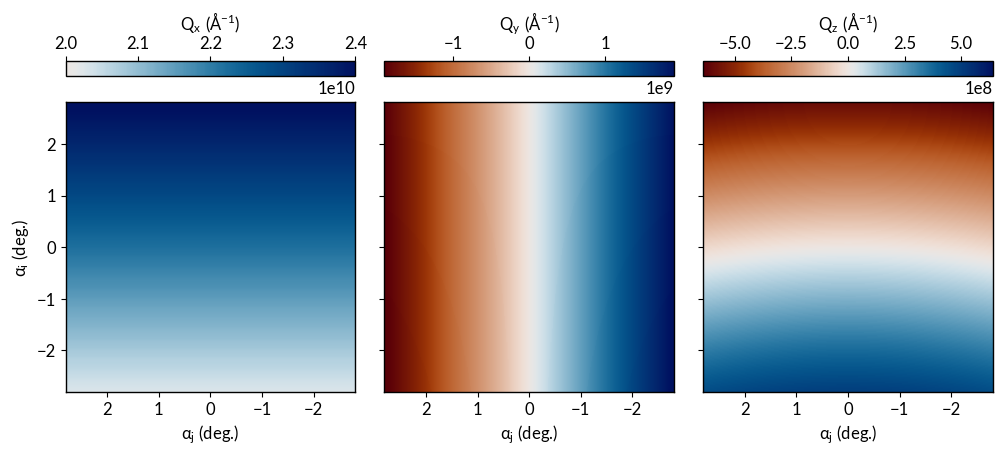

In [75]:
theta_B = torch.deg2rad(torch.tensor(15.79, dtype=dtype, device=device))
k_i = torch.tensor([torch.sin(-theta_B), 0.0, torch.cos(-theta_B)], dtype=dtype, device=device)
k_f = torch.tensor([torch.sin(theta_B), 0.0, torch.cos(theta_B)], dtype=dtype, device=device)

q_vectors = detector.calculate_q_vectors(k_i, k_f)
fig = detector.plot_q_vectors(q_vectors)

In [115]:
class Sample:
    """
    Class representing a crystal sample.
    """
    
    def __init__(
        self,
        cif_path: str,
        sample_size: Tuple[int, int, int],
        dtype: torch.dtype = torch.float32,
        device: str = 'cuda'
    ):
        """
        Initialize a Sample object.
        
        Parameters:
        -----------
        cif_path: str
            Path to cif file
        sample_size: tuple
            Tuple of integers (n1, n2, n3) specifying crystal size in unit cells
        dtype: torch.dtype
            torch data type
        device: str
            torch device ('cuda' or 'cpu')
        """
        self.cif_path = cif_path
        self.sample_size = sample_size
        self.dtype = dtype
        self.device = device

    def parse_cif_file(self):
        parser = CifParser(self.cif_path)
        structure = parser.parse_structures(primitive=False)[0]

        return structure

    def calculate_sample_properties(self, structure):
        self.lattice_vectors = torch.tensor(structure.lattice.matrix * 1e-10, dtype=self.dtype, device=self.device)
        self.atom_positions = torch.tensor(structure.cart_coords * 1e-10, dtype=self.dtype, device=self.device)
        try: self.atom_types = list(map(str, map(lambda x: x.element, structure.species)))
        except: self.atom_types = list(map(str, structure.species))
        self.n_atoms = len(self.atom_types)
        self.n_cells = self.sample_size[0] * self.sample_size[1] * self.sample_size[2]
        self.cell_volume = torch.det(self.lattice_vectors).abs()
        self.sample_volume = self.cell_volume * self.n_cells

    def make_displacement_field(self):
        self.displacement_field = 1e-10 * torch.randn(self.sample_size + self.atom_positions.shape, dtype=self.dtype, device=self.device)
        
    def align_miller_plane_to_axis(self, structure, miller_indices, target_axis='x'):
        """
        Rotate a crystal structure so that the normal to a specified Miller plane
        is aligned with a target axis.
        
        Parameters:
        -----------
        structure : pymatgen.core.Structure
            The crystal structure to rotate
        miller_indices : tuple
            Miller indices (h, k, l) of the plane
        target_axis : str
            Target axis ('x', 'y', or 'z')
        
        Returns:
        --------
        rotated_structure : pymatgen.core.Structure
            The rotated structure
        """
        
        # Define target direction vectors
        target_directions = {
            'x': np.array([1, 0, 0]),
            'y': np.array([0, 1, 0]),
            'z': np.array([0, 0, 1])
        }
        
        if target_axis not in target_directions:
            raise ValueError("target_axis must be 'x', 'y', or 'z'")
        
        target_direction = target_directions[target_axis]

        # Get the reciprocal lattice
        reciprocal_lattice = structure.lattice.reciprocal_lattice
        
        # Calculate the normal vector to the Miller plane
        # Normal to (h,k,l) plane = h*a* + k*b* + l*c* (reciprocal lattice vectors)
        h, k, l = miller_indices
        miller_normal = (h * reciprocal_lattice.matrix[0] + 
                         k * reciprocal_lattice.matrix[1] + 
                         l * reciprocal_lattice.matrix[2])
        
        # Normalize the normal vector
        miller_normal = miller_normal / np.linalg.norm(miller_normal)
        
        # Calculate the rotation axis (cross product)
        rotation_axis = np.linalg.cross(miller_normal, target_direction)
        rotation_axis_norm = np.linalg.norm(rotation_axis)
        
        if rotation_axis_norm < 1e-10:  # Already aligned or anti-aligned
            if np.dot(miller_normal, target_direction) > 0:
                # Already aligned, no rotation needed
                return structure.copy()
            else:
                # Anti-aligned, need 180° rotation
                # Choose a perpendicular axis for 180° rotation
                rotation_axis = np.roll(target_direction, shift = 1)
                rotation_angle = np.pi
        else:
            rotation_axis = rotation_axis / rotation_axis_norm
            
            # Calculate rotation angle
            rotation_angle = np.arccos(np.clip(np.dot(miller_normal, target_direction), -1.0, 1.0))
        
        # Apply rotation transformation
        transformation = RotationTransformation(rotation_axis, rotation_angle, angle_in_radians=True)
        rotated_structure = transformation.apply_transformation(structure)

        return rotated_structure
    
    def get_atomic_form_factors(self) -> List[Tensor]:
        self.atomic_form_factors = {
            'O': [3.0485, 13.2771, 2.2868, 5.7011, 1.5463, 0.3239, 0.867, 32.9089, 0.2508],
            'Zn': [14.0743, 3.2655, 7.0318, 0.2333, 5.1652, 10.3163, 2.41, 58.7097, 1.3041],
            'Ba': [14.0743, 3.2655, 7.0318, 0.2333, 5.1652, 10.3163, 2.41, 58.7097, 1.3041],
            'Ti': [14.0743, 3.2655, 7.0318, 0.2333, 5.1652, 10.3163, 2.41, 58.7097, 1.3041]
        }

        self.coeff_a = torch.zeros((1, self.n_atoms, 4), dtype=self.dtype, device=self.device)
        self.coeff_b = torch.zeros((1, self.n_atoms, 4), dtype=self.dtype, device=self.device)
        self.coeff_c = torch.zeros((1, self.n_atoms), dtype=self.dtype, device=self.device)
        
        for i, atom_type in enumerate(self.atom_types):
            self.coeff_a[:,i] = torch.tensor(self.atomic_form_factors[atom_type][0:-1:2], dtype=self.dtype, device=self.device)
            self.coeff_b[:,i] = torch.tensor(self.atomic_form_factors[atom_type][1:-1:2], dtype=self.dtype, device=self.device)
            self.coeff_c[:,i] = torch.tensor(self.atomic_form_factors[atom_type][-1], dtype=self.dtype, device=self.device)
        
    def calculate_form_factors(self, q_magnitude: Tensor) -> Tensor:
        gaussians = self.coeff_a.view(1,-1) * torch.exp(-self.coeff_b.view(1,-1) * (q_magnitude / (4 * torch.pi)) ** 2)
        
        return gaussians.view(-1, self.n_atoms, 4).sum(dim=-1) + self.coeff_c

In [116]:
sample = Sample(
    'BaTiO3.cif',
    sample_size = (50, 50, 50),
    dtype = dtype,
    device = device
)

structure = sample.parse_cif_file()
rotated_structure = sample.align_miller_plane_to_axis(structure, (1,1,0), target_axis='x')
sample.calculate_sample_properties(rotated_structure)
sample.make_displacement_field()
sample.get_atomic_form_factors()
lengths = sample.lattice_vectors.norm(dim=1)
print('Sample size:', ' nm x '.join('{:.1f}'.format(sample.sample_size[i] * lengths[i] * 1e9) for i in range(len(lengths))), 'nm')

Sample size: 20.0 nm x 20.0 nm x 20.0 nm


In [117]:
sample.displacement_field.shape

torch.Size([50, 50, 50, 5, 3])

In [118]:
# Note that Table 1 of Mokhtar et al. reports ΔX in nm but ΔX^3 in unit cells
# Empirically, results suggest that supercell approximation is only valid when d_i * a_i < ΔX / 2(?)
resolution = detector.calculate_resolution()
print(f'ΔX: {resolution:.2g} m')
print('ΔX:', ','.join('{:d}'.format(int(resolution / lengths[i].item())) for i in range(len(lengths))), 'cells')
print('ΔX^3:', '{:d}'.format(np.prod([int(resolution / lengths[i].item()) for i in range(len(lengths))])), 'cells')

ΔX: 1.6e-09 m
ΔX: 3,3,3 cells
ΔX^3: 27 cells


In [119]:
detector.calculate_oversampling_ratio(sample.sample_volume)

tensor(9.9947, device='cuda:0')

In [120]:
class BraggCoherentDiffraction:
    """
    Class for simulating Bragg coherent diffraction.
    """
    
    def __init__(
        self,
        sample: Sample,
        detector: Detector,
        dtype: torch.dtype = torch.float32,
        device: str = 'cuda'
    ):
        """
        Initialize a Bragg coherent diffraction simulator.
        
        Args:
            sample: Sample object
            detector: Detector object
            dtype: torch data type
            device: torch device ('cuda' or 'cpu')
        """
        self.sample = sample
        self.detector = detector
        self.dtype = dtype
        self.device = device
        
    def calculate_structure_factor(self, q_vectors: Tensor) -> Tensor:
        """
        Calculate the structure factor for a given set of q-vectors.
        
        Args:
            q_vectors: Tensor of shape [..., 3] containing q-vectors
            
        Returns:
            Structure factor as a complex tensor of shape [...]
        """
        # Store original shape of q_vectors for later reshaping
        batch_size_original = q_vectors.shape[:-1]
        
        # Reshape q_vectors to [batch_size, 3] for matrix multiplication
        q_vectors_flat = q_vectors.reshape(-1, 3)
        batch_size = q_vectors_flat.shape[0]
        
        # Calculate q·r for each atom in the unit cell and each q-vector
        # q_vectors_flat shape: [batch_size, 3]
        # atom_positions shape: [n_atoms, 3]
        # result shape: [batch_size, n_atoms]
        q_dot_r = torch.matmul(q_vectors_flat, self.sample.atom_positions.T)
        
        # Calculate |q| for form factor (convert to Å for typical form factor formulas)
        q_magnitude = torch.sum(q_vectors_flat, dim=1, keepdim=True) * 1e-10  # [batch_size, 1]

        # Vectorized calculation of form factors for all atoms and all q values
        form_factors = self.sample.calculate_form_factors(q_magnitude)
        
        # Calculate e^(-iq·r) for each atom and each q-vector
        # Result shape: [batch_size, n_atoms]
        phase_factors = torch.exp(-1j * q_dot_r)
        
        # Multiply by form factors and sum over atoms
        # result shape: [batch_size]
        structure_factor = torch.sum(form_factors * phase_factors, dim=1)
        
        # Reshape back to original q_vectors shape
        structure_factor = structure_factor.view(batch_size_original)
        
        return structure_factor
        
    def calculate_supercell_scattering(self, q_vectors: Tensor, supercell_size: Tuple[int, int, int]) -> Tensor:
        """
        Calculate scattering using the supercell approach from Mokhtar et al.
        
        Args:
            q_vectors: Tensor of shape [..., 3] containing q-vectors
            supercell_size: Size of supercells (d1, d2, d3) in unit cells
            
        Returns:
            Scattering amplitude as a complex tensor
        """
        d1, d2, d3 = supercell_size
        n1, n2, n3 = self.sample.sample_size
        
        # Generate supercell indices
        i_indices = torch.arange(0, n1, d1, dtype=self.dtype, device=self.device)
        j_indices = torch.arange(0, n2, d2, dtype=self.dtype, device=self.device)
        k_indices = torch.arange(0, n3, d3, dtype=self.dtype, device=self.device)
        
        # Compute a grid of all indices
        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='ij')

        # Reshape to [n_supercells, 3]
        supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)
        
        # Calculate positions in real space
        supercell_positions = torch.matmul(supercell_indices, self.sample.lattice_vectors)
        
        # Store original shape of q_vectors for later reshaping
        batch_size_original = q_vectors.shape[:-1]
        
        # Reshape q_vectors to [batch_size, 3] for matrix multiplication
        q_vectors_flat = q_vectors.reshape(-1, 3)
        batch_size = q_vectors_flat.shape[0]
        
        # Calculate q·R for each supercell and each q-vector
        q_dot_R = torch.matmul(q_vectors_flat, supercell_positions.T)
        
        # Calculate structure factor for the unit cell
        S_q = self.calculate_structure_factor(q_vectors_flat)
        
        # Calculate phase factor for each supercell
        # Result shape: [batch_size, n_supercells]
        phase_factors = torch.exp(-1j * q_dot_R)
        
        # Number of unit cells per supercell
        cells_per_supercell = d1 * d2 * d3
        
        # Multiply structure factor by sum of phase factors and scale by supercell size
        # Result shape: [batch_size]
        scattering_amplitude = S_q * torch.sum(phase_factors, dim=1) * cells_per_supercell
        
        # Reshape back to original q_vector shape
        scattering_amplitude = scattering_amplitude.reshape(batch_size_original)
        
        return scattering_amplitude

    def calculate_supercell_scattering_with_displacements(self, q_vectors: Tensor, supercell_size: Tuple[int, int, int]) -> Tensor:
        """
        Calculate scattering using the supercell approach from Mokhtar et al. with averaged displacements for each supercell.
        
        Args:
            q_vectors: Tensor of shape [..., 3] containing q-vectors
            supercell_size: Size of supercells (d1, d2, d3) in unit cells
            
        Returns:
            Scattering amplitude as a complex tensor
        """
        d1, d2, d3 = supercell_size
        n1, n2, n3 = self.sample.sample_size
        
        # Check if dimensions divide evenly
        assert (n1 % d1 == 0) and (n2 % d2 == 0) and (n3 % d3 == 0)

        n_sc_1, n_sc_2, n_sc_3 = n1 // d1, n2 // d2, n3 // d3
        
        # Calculate averaged displacements
        n_atoms = self.sample.displacement_field.shape[3]
        
        # Reshape to group unit cells into supercells: [n_sc_1, d1, n_sc_2, d2, n_sc_3, d3, n_atoms, 3]
        grouped = self.sample.displacement_field.reshape(n_sc_1, d1, n_sc_2, d2, n_sc_3, d3, n_atoms, 3)
        
        # Average over supercell dimensions (1, 3, 5) -> [n_sc_1, n_sc_2, n_sc_3, n_atoms, 3]
        avg_displacements = torch.mean(grouped, dim=(1, 3, 5))
        
        # Flatten to [n_supercells, n_atoms, 3]
        avg_displacements_flat = avg_displacements.reshape(-1, n_atoms, 3)
        
        # Generate supercell indices
        i_indices = torch.arange(0, n1, d1, dtype=self.dtype, device=self.device)
        j_indices = torch.arange(0, n2, d2, dtype=self.dtype, device=self.device)
        k_indices = torch.arange(0, n3, d3, dtype=self.dtype, device=self.device)
        
        # Compute a grid of all indices
        # Meshgrid order must match the reshape flattening order
        # avg_displacements has shape [n_sc_1, n_sc_2, n_sc_3, n_atoms, 3]
        # When flattened, linear_index = i*n_sc_2*n_sc_3 + j*n_sc_3 + k
        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='ij')

        # Reshape to [n_supercells, 3]
        supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)
        
        # Calculate positions in real space
        supercell_positions = torch.matmul(supercell_indices, self.sample.lattice_vectors)
        
        # Store original shape of q_vectors for later reshaping
        batch_size_original = q_vectors.shape[:-1]
        
        # Reshape q_vectors to [batch_size, 3] for matrix multiplication
        q_vectors_flat = q_vectors.reshape(-1, 3)
        batch_size = q_vectors_flat.shape[0]

        # Calculate |q| for form factor (convert to Å for typical form factor formulas)
        q_magnitude = torch.sum(q_vectors_flat, dim=1, keepdim=True) * 1e-10  # [batch_size, 1]

        # Vectorized calculation of form factors for all atoms and all q values
        form_factors = self.sample.calculate_form_factors(q_magnitude)  # [batch_size, n_atoms]

        # Vectorized calculation of all q·u_m terms
        # q_vectors_flat: [batch_size, 3]
        # avg_displacements_flat: [n_supercells, n_atoms, 3]
        # Result: [batch_size, n_supercells, n_atoms]
        q_dot_displacements = torch.einsum('bi,smi->bsm', q_vectors_flat, avg_displacements_flat)
        displacement_phase_factors = torch.exp(-1j * q_dot_displacements)

        # Calculate structure factor for the unit cell
        modified_structure_factors = torch.sum(
            form_factors.unsqueeze(1) * displacement_phase_factors, dim=2
        )

        # Calculate q·R for each supercell and each q-vector
        q_dot_R = torch.matmul(q_vectors_flat, supercell_positions.T)
        supercell_phase_factors = torch.exp(-1j * q_dot_R)

        # Number of unit cells per supercell
        cells_per_supercell = d1 * d2 * d3
        
        # Multiply modified structure factor by sum of phase factors and scale by supercell size
        # Result shape: [batch_size]
        scattering_amplitude = torch.sum(modified_structure_factors * supercell_phase_factors, dim=1) * cells_per_supercell

        # Reshape back to original q_vector shape
        scattering_amplitude = scattering_amplitude.reshape(batch_size_original)
        
        return scattering_amplitude

In [121]:
simulator = BraggCoherentDiffraction(
    sample = sample,
    detector = detector,
    dtype = dtype,
    device = device
)

In [122]:
t0 = time.time()
amplitude = simulator.calculate_structure_factor(q_vectors)
intensity = (amplitude.abs() ** 2)
print(time.time() - t0)

0.0009317398071289062


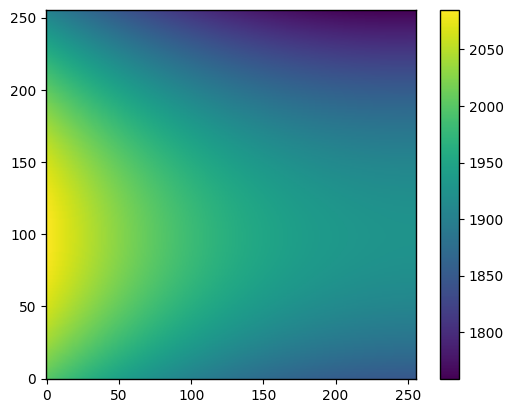

In [123]:
fig, ax = plt.subplots()
norm = plt.Normalize()
sm = ax.imshow(intensity.cpu(), origin='lower')
plt.colorbar(sm);

In [124]:
t0 = time.time()
amplitude = simulator.calculate_supercell_scattering(q_vectors, (5,5,5))
intensity = (amplitude.abs() ** 2)
print(time.time() - t0)

0.0010921955108642578


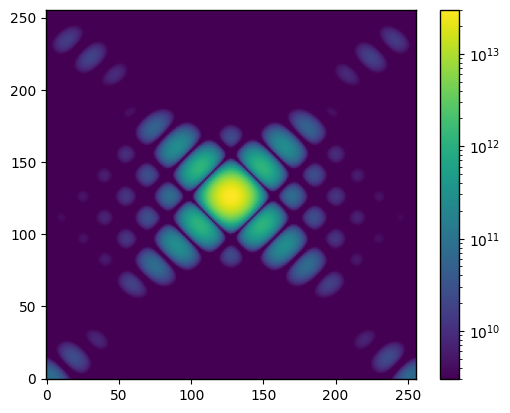

In [125]:
fig, ax = plt.subplots()
vmax = detector.round_in_base(intensity.max().item(), digits=1)
vmin = vmax / 1e4

norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = ax.imshow(intensity.cpu(), origin='lower', norm=norm)
plt.colorbar(sm);

In [126]:
t0 = time.time()
amplitude = simulator.calculate_supercell_scattering_with_displacements(q_vectors, (5,5,5))
intensity = (amplitude.abs() ** 2)
print(time.time() - t0)

0.0012671947479248047


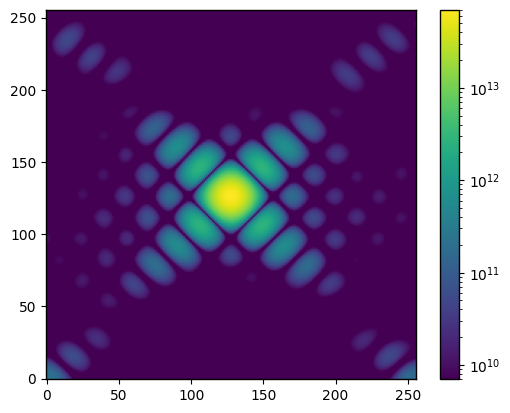

In [127]:
fig, ax = plt.subplots()
vmax = detector.round_in_base(intensity.max().item(), digits=1)
vmin = vmax / 1e4

norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = ax.imshow(intensity.cpu(), origin='lower', norm=norm)
plt.colorbar(sm);

In [141]:
t0 = time.time()
amplitude = simulator.calculate_supercell_scattering(q_vectors, (4,4,4))
intensity = (amplitude.abs() ** 2)
print(time.time() - t0)

3.7641332149505615


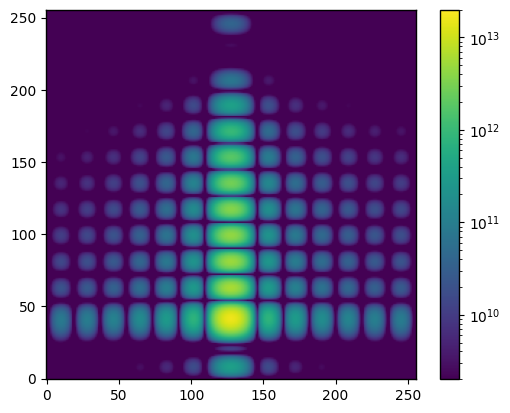

In [142]:
fig, ax = plt.subplots()
vmax = detector.round_in_base(intensity.max().item(), digits=1)
vmin = vmax / 1e4

norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = ax.imshow(intensity.cpu(), origin='lower', norm=norm)
plt.colorbar(sm);

In [ ]:
# Look up Thompson scattering length and add other prefactors
# Get fringes!
# Get speckles!